In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

import d2l

Mounted at /content/gdrive


# 1. Given a directional vector (*v1, v2*), derive an edge-detection kernel that detects edges orthogonal to *v*, i.e., edges in the direction (*v2, -v1*)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


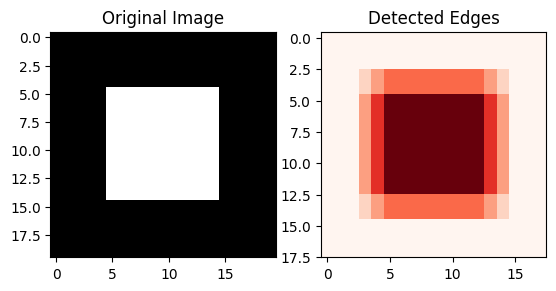

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def edge_detection_kernel(v1, v2, kernel_size=3):
    # Normalize the directional vector
    direction = torch.tensor([v1, v2], dtype=torch.float32)
    direction /= direction.norm()

    # Generate a 2D grid for the convolution kernel
    x, y = torch.meshgrid(torch.arange(-1, 2).float(), torch.arange(-1, 2).float())

    # Compute the dot product of each grid point with the normalized directional vector
    dot_product = x * direction[0] + y * direction[1]

    # Create the edge-detection kernel by emphasizing changes along the orthogonal direction
    kernel = torch.abs(dot_product)

    # Normalize the kernel to sum to 1
    kernel /= kernel.sum()

    return kernel

def visualize_image_and_edges(image, edges):
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='Reds')
    plt.title('Detected Edges')

    plt.show()

# Example: Test edge-detection kernel on a binary image
image_size = 20
image = torch.zeros(image_size, image_size)
image[5:15, 5:15] = 1  # Add a vertical edge to the image

# Design edge-detection kernel for vertical edges
v1, v2 = 1,0 # observe that this is a horizontal vector
kernel = edge_detection_kernel(v1, v2)

# Apply convolution to detect edges
edges = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))

# Visualize the original image and detected edges
visualize_image_and_edges(image.numpy(), edges[0, 0].numpy())


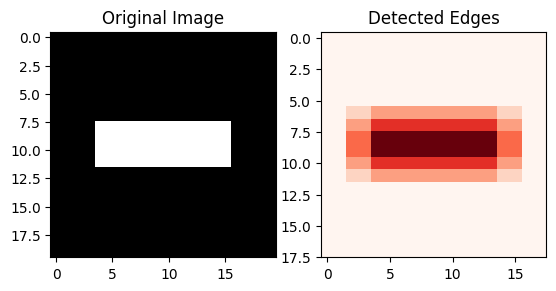

In [ ]:
# Example: Test edge-detection kernel on a binary image
image_size = 20
image = torch.zeros(image_size, image_size)
image[8:12, 4:16] = 1  # Add a horizontal edge to the image

# Design edge-detection kernel for horizontal edges
v1, v2 = 0,1
kernel = edge_detection_kernel(v1, v2)

# Apply convolution to detect edges
edges = F.conv2d(image.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0))

# Visualize the original image and detected edges
visualize_image_and_edges(image.numpy(), edges[0, 0].numpy())

As you can see for the second result above, a darker red shade is displayed for the pixels along the horizontal border, which is perpendicular to the given vector (0, 1). Therefore the edge detection works properly.

# 2. Derive a finite difference operator for the second derivative. What is the minimum size of the convolutional kernel associated with it? Which structures in images respond most strongly to it?

We can utilize the central difference formula to approximate the second derivative.

f''(x) = [f(x+h) - 2 f(x) + f(x-h)]/h^2 where h is the step size.

In this case, the resulting kernel would look like K = 1/h^2 [1, -2, 1].

Therefore, the size must be 3x1.

In images, structures that respond most strongly to the second derivative kernel are edges and corners. This is because edges and corners exhibit rapid changes in intensity, which corresponds to high values of the second derivative. Therefore, convolving an image with the second derivative kernel highlights these features, making them more prominent in the resulting image.






# 3. How would you design a blur kernel? Why might you want to use such a kernel?

Designing a blur kernel involves creating a convolutional kernel that distributes the intensity of each pixel to its neighboring pixels, effectively reducing the high-frequency components in the image.

One blur kernel, the Gaussian blur kernel, uses a the standard deviation (sigma) of a Gaussian distribution to create the kernel. A large sigma creates a lot of blur and vice versa.

Blur kernels are useful for the following reasons:

- Noise reduction / smoothing out images
- Preprocessing for computer vision (get rid of extraneous information).
- privacy protection.

Below is an example of using a Gaussian blur filter on an image. Feel free to upload your own image to test it.

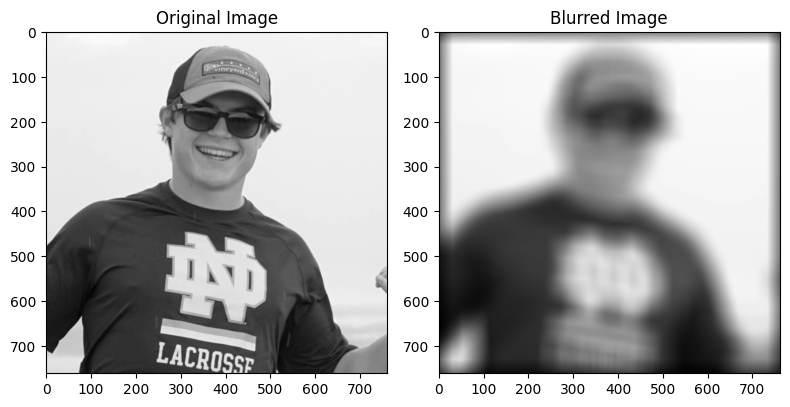

In [4]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def create_gaussian_kernel(kernel_size, sigma):
    """
    Create a 2D Gaussian kernel with the given size and standard deviation.
    """
    kernel_range = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    kernel_values = torch.exp(-0.5 * (kernel_range.float() / sigma) ** 2)
    kernel_values /= kernel_values.sum()
    kernel = kernel_values.unsqueeze(0) * kernel_values.unsqueeze(1)
    return kernel

def blur_image(image, kernel_size, sigma):
    """
    Apply Gaussian blur to the input image using the specified kernel size and sigma.
    """
    # Convert image to tensor
    image_tensor = torch.tensor(np.array(image)).float().unsqueeze(0).unsqueeze(0) / 255.0

    # Create Gaussian kernel
    kernel = create_gaussian_kernel(kernel_size, sigma)
    kernel = kernel.unsqueeze(0).unsqueeze(0)

    # Apply convolution using PyTorch's functional interface
    blurred_image = F.conv2d(image_tensor, kernel, padding=kernel_size//2)

    return blurred_image.squeeze().numpy()

# Load example image
# image_path = "IMG_1935.HEIC"
image_path = "IMG_3481.jpg"
image = Image.open(image_path).convert("L")  # Convert to grayscale
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image")

# Apply Gaussian blur
blurred_image = blur_image(image, kernel_size=60, sigma=100)
plt.subplot(1, 2, 2)
plt.imshow(blurred_image, cmap="gray")
plt.title("Blurred Image")

plt.tight_layout()
plt.show()


# 4. What is the minimum size of a kernel to obtain a derivative of order d?

Generally, the kernel must be of at least size d+1 in order to obtain a derivative of order d. As shown in the example in part 2 above, to obtain the second derivative (d=2), the kernel size is d+1 = 2+1 = 3.